# Causal Impact: Advanced Control Selection & Rationale

This notebook demonstrates a **Multi-Layer Robustness** framework for Causal Inference. We don't just pick cities that look like Barcelona; we put them through a statistical 'stress test' to ensure they are true behavioral twins.

## 1. The Rationale: Why standard correlation is dangerous
In time series, **Correlation != Connection**. Most business metrics share a 'General Trend' (e.g., inflation, seasonal growth). If you pick controls based on this trend, you fall into the **Spurious Correlation Trap**.

### 🔬 Test 1: Stationarity & The 'Rainy Tuesday' (Behavioral Shocks)
*   **The Idea:** We strip away the trend (Differencing/Log) to see the **Daily Shocks**.
*   **Example:** Imagine **Sunglasses** and **Ice Cream**. In summer, both go up (High Raw Correlation). But if you have a random rainy Tuesday, the trend disappears. If both metrics drop *only* on that specific day, they are behaviorally synchronized.
*   **Why it matters:** This ensures the model reacts correctly to unexpected external events, preventing the prediction from 'drifting' away from reality.

### 🎯 Test 2: Granger Causality (Predictive Information)
*   **The Idea:** We check if the control city's past actually helps us predict Barcelona's future.
*   **Example:** If City A is a 'leading indicator' (e.g., people there see the ads two days before Barcelona), it provides high-quality predictive intent to the model.
*   **Why it matters:** It identifies cities that are not just coincidental, but share a dynamic 'information flow' with our target.

### ⚖️ Test 3: Variance Ratio (Volatility Matching)
*   **The Idea:** We ensure the control has a similar 'swing' or noise level as Barcelona.
*   **Example:** Don't use a **small-town convenience store** (high daily volatility) to predict a **big-city flagship store** (stable volume), even if they follow the same trend. The noise from the small store will make the model's confidence intervals too wide.
*   **Why it matters:** This keeps the model's 'Standard Error' low, making it easier to prove a small +5% or +10% lift is statistically significant.

## 📉 The Selection Hierarchy
1.  **✅ PASS (All Tests):** Highly correlated, properly scaled, and carries predictive intent.
2.  **🆗 ELIGIBLE:** A strong behavioral match but lacks predictive leading-indicator status.
3.  **⚠️ VOLATILE:** Matches behavior but is either too 'wiggly' or too 'flat' compared to Barcelona.
4.  **📉 TIER 2:** A weaker match used only if no perfect twins exist (ensures the analysis can still run).

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from causalimpact import CausalImpact
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Load Data

In [ ]:
df_long = pd.read_csv('sales_data.csv')
df_long['Date'] = pd.to_datetime(df_long['Date'])

# Pivot the long format data back to wide format for analysis
df = df_long.pivot(index='Date', columns='City', values='Value')

print(f"Dataset loaded in LONG format and pivoted to WIDE. Total columns: {len(df.columns)}")
df.head()

Dataset loaded in LONG format and pivoted to WIDE. Total columns: 23


City,Barcelona,City_1,City_10,City_11,City_12,City_13,City_14,City_15,City_16,City_17,...,City_20,City_3,City_4,City_5,City_6,City_7,City_8,City_9,City_High_Variance,City_Spurious
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,55.854656,39.712217,28.089523,34.836857,46.613520,28.168061,45.380621,54.078475,39.800021,46.323261,...,24.908969,43.304386,30.283184,37.057484,20.308004,28.762104,44.967152,44.344031,32.284672,52.986501
2023-01-02,55.994556,33.722632,24.565855,37.978283,47.083444,36.561866,46.351402,60.986632,38.225280,46.826904,...,34.367665,50.043423,30.347813,36.633057,35.560624,39.811735,45.631656,45.228758,31.082511,40.509138
2023-01-03,57.755151,39.582261,31.168374,39.527345,46.444711,33.257862,48.791109,57.797018,43.406532,48.408094,...,45.705955,37.281488,39.483341,45.997545,48.566768,29.799348,46.495116,47.058800,63.768096,34.133827
2023-01-04,60.569458,35.414180,28.803068,41.698916,48.809497,33.207046,49.863821,65.203093,33.164871,49.371317,...,40.858315,45.826698,24.990306,45.970801,32.373581,32.742934,46.805649,49.611827,63.868827,52.856974
2023-01-05,56.905429,30.020873,30.502913,33.742957,48.684859,44.662952,46.482838,60.664593,47.366434,45.735821,...,34.712845,18.423150,31.162213,31.361569,31.805767,38.131569,48.103758,48.496523,54.976776,52.040193


## 2. Refined Selection Step (Sequential Stationarity)

We evaluate each of the 20 cities. A city is selected if it has high correlation AND can be made stationary through our standard pipeline.

In [ ]:
def get_stationary_transform(series, seasonal_period=7):
    """Returns (step_name, transform_func) or (None, None)."""
    def is_stationary(s):
        try:
            return adfuller(s.dropna())[1] < 0.05
        except:
            return False

    if is_stationary(series):
        return "Raw", lambda s: s
    
    try:
        s_log = np.log(series)
        if is_stationary(s_log): return "Log", lambda s: np.log(s)
        
        s_diff = s_log.diff()
        if is_stationary(s_diff): return "Log+Diff", lambda s: np.log(s).diff()
        
        s_seasonal = s_diff.diff(seasonal_period)
        if is_stationary(s_seasonal): 
            return "Log+Diff+Seasonal", lambda s: np.log(s).diff().diff(seasonal_period)
    except:
        pass
        
    return None, None

def select_best_controls(df_full, target, pre_beg, pre_end, t1_thresh=0.8, t2_thresh=0.6):
    df_pre = df_full.loc[pre_beg:pre_end]
    print(f"Selection tests applied to range: {df_pre.index.min()} to {df_pre.index.max()}")
    potential_controls = [c for c in df_full.columns if c != target]
    
    results = []
    for city in potential_controls:
        corr_raw = df_pre[target].corr(df_pre[city])
        step_name, transform_func = get_stationary_transform(df_pre[city])
        
        corr_trans = None
        granger_p = None
        var_ratio = None
        
        if step_name:
            s_city_trans = transform_func(df_pre[city]).dropna()
            s_target_trans = transform_func(df_pre[target]).dropna()
            
            # Behavioral Correlation
            joined = pd.concat([s_city_trans, s_target_trans], axis=1).dropna()
            corr_trans = joined.iloc[:, 0].corr(joined.iloc[:, 1])
            
            # Granger Causality
            try:
                granger_result = grangercausalitytests(joined[[target, city]], maxlag=2, verbose=False)
                granger_p = granger_result[1][0]['params_ftest'][1]
            except: granger_p = 1.0
            
            # Variance Ratio (Volatility Matching)
            var_ratio = s_city_trans.std() / s_target_trans.std()
        
        # Initial Assignment with Variance and Correlation Filter
        tier = "None"
        if corr_trans and corr_trans > t1_thresh:
            if 0.5 < var_ratio < 2.0:
                tier = "Tier 1 (Strict)"
            else:
                tier = "Rejected (High Variance)"
        elif corr_trans and corr_trans > t2_thresh and corr_raw > t2_thresh:
            tier = "Tier 2 (Fallback)"
        
        results.append({
            'City': city,
            'Correlation_Raw': corr_raw,
            'Correlation_Transformed': corr_trans,
            'Granger_p_value': granger_p,
            'Variance_Ratio': var_ratio,
            'Selection_Tier': tier
        })
    
    matrix = pd.DataFrame(results)
    
    # Final Selection Logic
    t1_cities = matrix[matrix['Selection_Tier'] == "Tier 1 (Strict)"]['City'].tolist()
    if t1_cities:
        selected = t1_cities
        status = f"Using Tier 1 (Strict) selection."
    else:
        t2_cities = matrix[matrix['Selection_Tier'] == "Tier 2 (Fallback)"]['City'].tolist()
        selected = t2_cities
        status = "No Tier 1 cities found. Falling back to Tier 2." if t2_cities else "No eligible cities found."
        
    return matrix, selected, status

pre_beg, pre_end = '2023-01-01', '2023-05-30'
target_col = 'Barcelona'
selection_matrix, selected_cities, selection_status = select_best_controls(df, target_col, pre_beg, pre_end)

print(f"--- {selection_status} ---")
print(selection_matrix.sort_values('Correlation_Transformed', ascending=False))
print(f"\nFinal Selected Control Cities: {selected_cities}")

Selection tests applied to range: 2023-01-01 00:00:00 to 2023-05-30 00:00:00
--- Using Tier 1 (Strict) selection. ---
                  City  Correlation_Raw  Correlation_Transformed  \
9              City_18         0.988890                 0.988890   
8              City_17         0.987127                 0.804349   
10             City_19         0.984564                 0.795399   
19              City_9         0.985540                 0.786423   
11              City_2         0.984752                 0.767210   
3              City_12         0.987004                 0.765503   
7              City_16         0.821826                 0.273973   
20  City_High_Variance         0.520731                 0.168207   
13              City_3         0.150171                 0.150171   
4              City_13         0.161150                 0.130827   
2              City_11         0.837450                 0.120160   
17              City_7         0.111524                 0.111524  

C:\Users\benoi\AppData\Roaming\Python\Python314\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\benoi\AppData\Roaming\Python\Python314\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\benoi\AppData\Roaming\Python\Python314\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\benoi\AppData\Roaming\Python\Python314\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\benoi\AppData\Roaming\Python\Python314\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\benoi\AppData\Roaming\Python\Py

### 💡 Why we check Transformed Correlation

Look at **City_Spurious** in the matrix above:
- **Raw Correlation** is likely very high (> 0.9) because it shares the same trend/seasonality as Barcelona.
- **Transformed Correlation** is low because its daily 'shocks' are independent.

By enforcing **Tier 1 (Transformed > 0.8)**, we ensure that our controls are behaviorally synchronized, not just 'coincidentally growing' at the same rate. This prevents the model from relying on spurious relationships that could drift in the post-period.

## 3. Visualize Selection Results

C:\Users\benoi\AppData\Local\Temp\ipykernel_13144\632261534.py:40: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\benoi\AppData\Local\Temp\ipykernel_13144\632261534.py:40: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\benoi\AppData\Local\Temp\ipykernel_13144\632261534.py:40: UserWarning: Glyph 127383 (\N{SQUARED OK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\benoi\AppData\Local\Temp\ipykernel_13144\632261534.py:40: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\benoi\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\benoi\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WIT

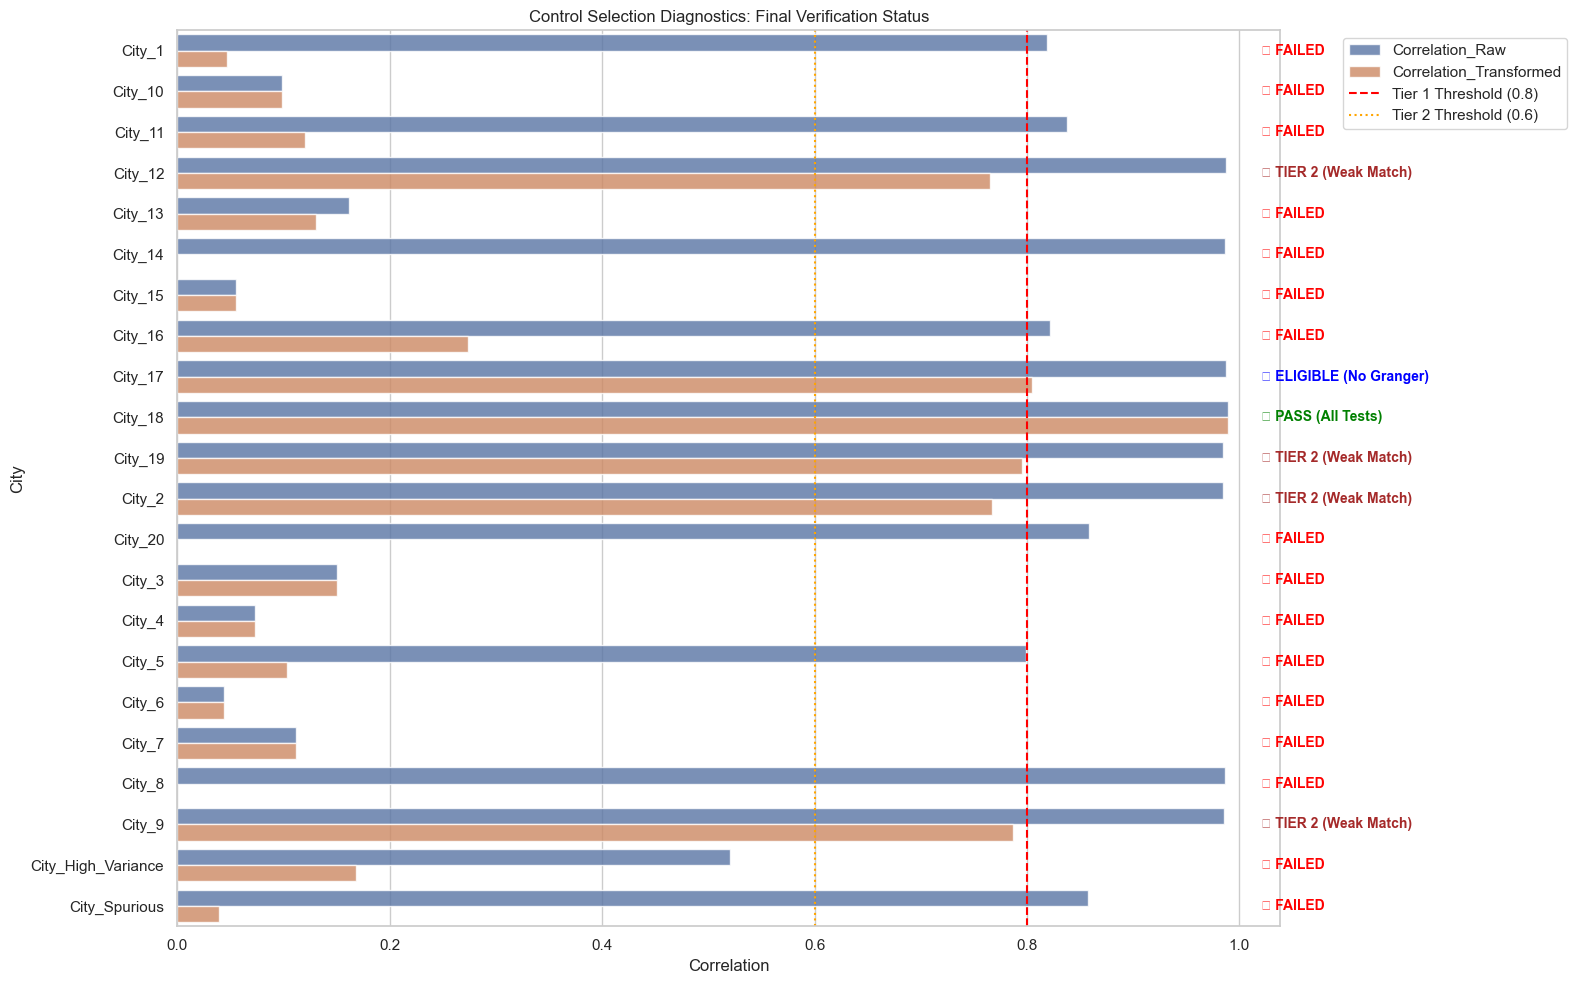

In [ ]:
plt.figure(figsize=(16, 10))
comparison_df = selection_matrix.melt(id_vars=['City', 'Selection_Tier', 'Granger_p_value', 'Variance_Ratio'], 
                                       value_vars=['Correlation_Raw', 'Correlation_Transformed'],
                                       var_name='Type', value_name='Correlation')

sns.barplot(data=comparison_df, x='Correlation', y='City', hue='Type', alpha=0.8)
plt.axvline(0.8, color='red', linestyle='--', label='Tier 1 Threshold (0.8)')
plt.axvline(0.6, color='orange', linestyle=':', label='Tier 2 Threshold (0.6)')

for i, city in enumerate(selection_matrix['City']):
    row = selection_matrix.loc[selection_matrix['City'] == city].iloc[0]
    
    is_tier1 = row['Selection_Tier'] == "Tier 1 (Strict)"
    is_granger = row['Granger_p_value'] < 0.05
    is_var_ok = (0.5 < row['Variance_Ratio'] < 2.0) if row['Variance_Ratio'] is not None else False
    
    status_text = ""
    color = 'black'
    
    if is_tier1 and is_granger:
        status_text = "✅ PASS (All Tests)"
        color = 'green'
    elif is_tier1:
        status_text = "🆗 ELIGIBLE (No Granger)"
        color = 'blue'
    elif row['Selection_Tier'] == "Rejected (High Variance)":
        status_text = "⚠️ VOLATILE (Failed Var)"
        color = 'orange'
    elif row['Selection_Tier'] == "Tier 2 (Fallback)":
        status_text = "📉 TIER 2 (Weak Match)"
        color = 'brown'
    else:
        status_text = "❌ FAILED"
        color = 'red'
        
    plt.text(1.02, i, status_text, va='center', color=color, fontweight='bold', fontsize=10)

plt.title('Control Selection Diagnostics: Final Verification Status')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 4. Causal Impact Analysis

We use the original data for selected controls, knowing they are statistically robust.

C:\Users\benoi\AppData\Roaming\Python\Python314\site-packages\causalimpact\main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
C:\Users\benoi\AppData\Roaming\Python\Python314\site-packages\causalimpact\main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
C:\Users\benoi\AppData\Roaming\Python\Python314\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benoi\AppData\Roaming\Python\Python314\site-packages\statsmodels\base\optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed ke

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    91.04              4552.06
Prediction (s.d.)         70.3 (0.46)        3515.05 (22.87)
95% CI                    [69.43, 71.22]     [3471.5, 3561.14]

Absolute effect (s.d.)    20.74 (0.46)       1037.01 (22.87)
95% CI                    [19.82, 21.61]     [990.93, 1080.57]

Relative effect (s.d.)    29.5% (0.65%)      29.5% (0.65%)
95% CI                    [28.19%, 30.74%]   [28.19%, 30.74%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


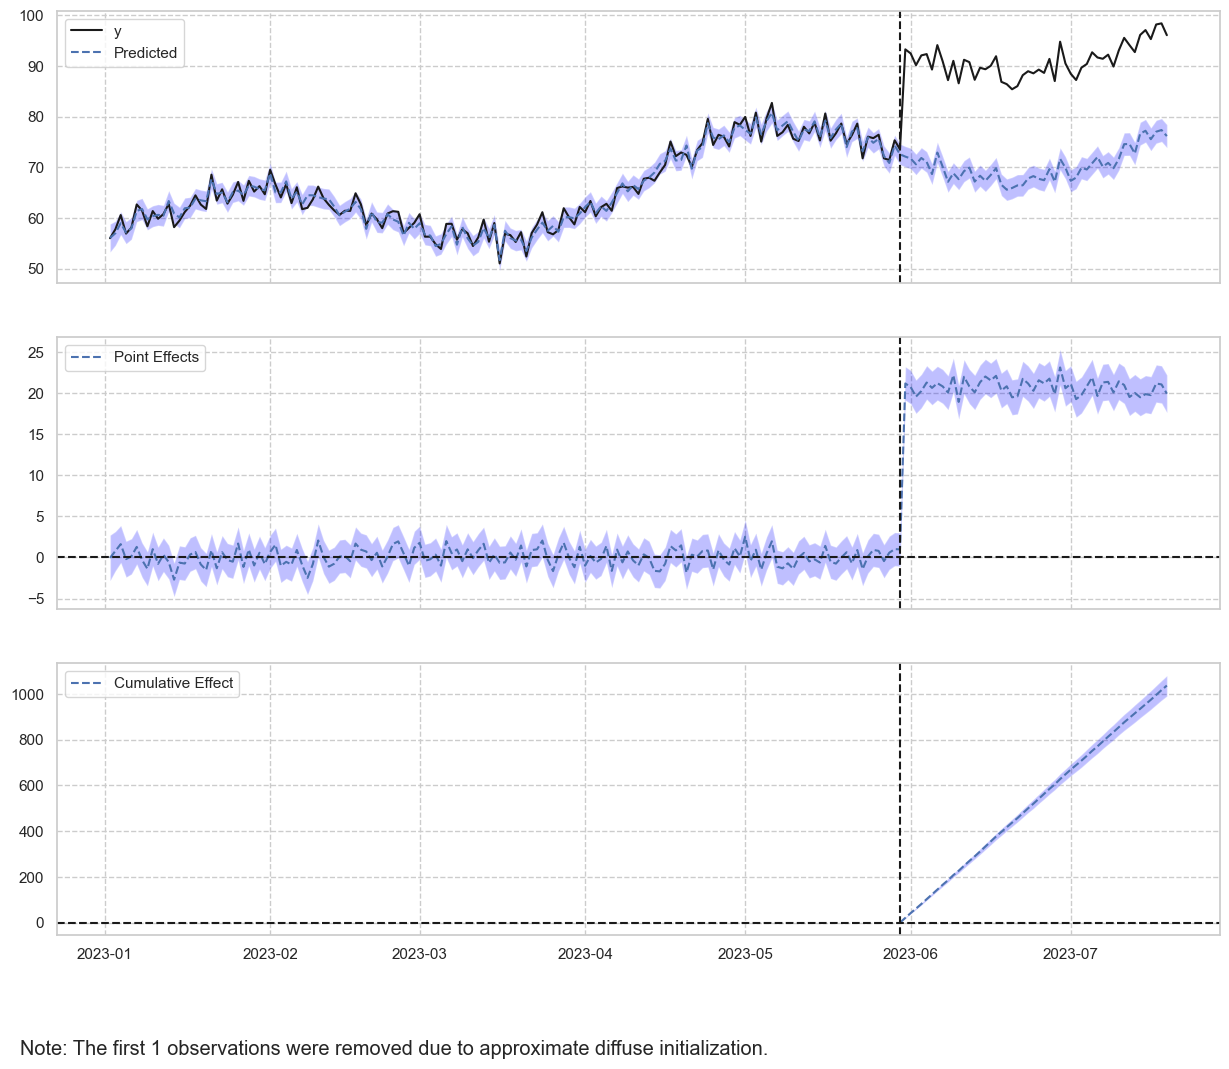

In [ ]:
if selected_cities:
    model_data = df[[target_col] + selected_cities]
    ci = CausalImpact(model_data, pre_period, post_period)
    print(ci.summary())
    # print(ci.summary(output='report'))
    ci.plot()
else:
    print("ERROR: No cities met the strict selection criteria.")